<h1 style="text-align: center">
Deep Learning HW4 </br>
VQ-VAE
</h1>

### Full Name: Borna khodabandeh
### Student ID: 400109898

# VQ-VAE Implementation in PyTorch

This Jupyter notebook presents the implementation of a Vector Quantized Variational Autoencoder (VQ-VAE) using PyTorch. VQ-VAEs are a type of autoencoder/generator model that combines elements of variational autoencoders (VAEs) and vector quantization. The goal is to understand the key components of VQ-VAEs and demonstrate their application.

## Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")

using cuda device


## Data Loading

for this task we will be using the MNIST dataset for a simple benchmark for VQ-VAE models.

In [ ]:
import os
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False)

## Encoder and Decoder

This code defines the architecture for both the encoder and decoder components of a Variational Autoencoder (VAE).

The `Encoder` architecture consists of four convolutional blocks, each employing ReLU activation functions and batch normalization. Two residual connections are introduced to improve the flow of information through the network.

The `Decoder` class defines a decoder network using transposed convolutional layers to reconstruct the input, following a similar architecture to the Encoder but reversed.

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim=512):
        super(Encoder, self).__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, output_dim, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(output_dim)
        # Bottleneck conv
        self.residual_conv1 = nn.Conv2d(128, 256, kernel_size=1)
        self.residual_conv2 = nn.Conv2d(256, output_dim, kernel_size=1)
        # Activation
        self.act = nn.ReLU()

    def forward(self, x):
        # First block
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        # Second block
        res = self.residual_conv1(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = res + x
        res = self.residual_conv2(x)
        x = self.act(self.bn4(self.conv4(x)))
        y = res + x
        return y

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(Decoder, self).__init__()
        # Transposed Conv layers
        self.deconv4 = nn.ConvTranspose2d(input_dim, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, output_dim, kernel_size=4, stride=2, padding=1)
        # Activation
        self.act = nn.ReLU()

    def forward(self, x):
        # Third block
        x = self.act(self.bn4(self.deconv4(x)))
        # Second block
        x = self.act(self.bn3(self.deconv3(x)))
        # First block
        x = self.act(self.bn2(self.deconv2(x)))
        y = self.deconv1(x)
        return y

# Test 
enc = Encoder(1)
dec = Decoder(512)
for x, _ in train_loader:
    z = enc(x)
    y = dec(z)
    print(y.shape)
    print(f"Encoded data shape: {z.shape}")
    break

torch.Size([256, 1, 28, 28])
Encoded data shape: torch.Size([256, 512, 7, 7])


## Vector Quantizer

This code implements `VectorQuantizer`, the Vector Quantization (VQ) layer used in a Vector Quantized Variational Autoencoder (VQ-VAE).

the layer returns the closest vector in the codebook from the input vector. returning the quantized vector.

Various losses, including codebook loss, commitment loss, and perplexity, are calculated and returned.

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -1.0, 1.0)
        
    def forward(self, x):
        # Flatten input tensor
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flat = x.view(-1, self.embedding_dim)
        
        # Find nearest embeddings
        distances = torch.sum(x_flat ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(x_flat, self.embedding.weight.t())
        indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(indices.shape[0], self.num_embeddings).to(x.device)
        encodings.scatter_(1, indices, 1)

        # Quantize input
        quantized = torch.matmul(encodings, self.embedding.weight).view(x.shape)

        # Losses
        codebook_loss = F.mse_loss(x.detach(), quantized)
        commitment_loss = F.mse_loss(x, quantized.detach())
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, commitment_loss, codebook_loss, perplexity

## VQ-VAE Model

here we simply define the whole VQ-VAE model which combines the Encoder, Vector Quantizer (Codebook), and Decoder components.

to propagate the gradients properly, and copy them from the decoder to the encoder we use a simple trick by passing the following to the decoder:

$$
    z_{grad flow} = z_{enc} + sg[z_{quantized} - z_{enc}]
$$

In [5]:
class VQ_VAE(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(VQ_VAE, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        z_grad_flow = z + (z_quantized - z).detach()
        x_hat = self.decoder(z_grad_flow)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

### Defining the model

In [6]:
num_embeddings = 3
embedding_dim = 2

encoder = Encoder(input_dim=1, output_dim=embedding_dim)
codebook = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=embedding_dim, output_dim=1)

model = VQ_VAE(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)
recon = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

beta = 0.25

model

VQ_VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_conv1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (residual_conv2): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (act): ReLU()
  )
  (codebook): VectorQuantizer(
    (embedding): Embedding(3, 2)
  )
  (decoder): Decoder(
    (deconv4): ConvTranspose2

## Training the model

In [7]:
from tqdm import tqdm

num_epochs = 30
print_idx = 2

model.train()
train_losses = []
train_perplexities = []
codebook_vectors_list = []

for epoch in range(num_epochs):
    overall_loss = 0
    overall_perplexity = 0

    for (x, _) in tqdm(train_loader, desc=f'Training epoch {epoch+1}/{num_epochs}'):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = recon(x_hat, x)
        
        loss = recon_loss + codebook_loss + beta * commitment_loss
        
        overall_loss += loss.item()
        overall_perplexity += perplexity.item()

        loss.backward()
        optimizer.step()

    # Calculate mean loss and mean perplexity for the epoch
    mean_loss = overall_loss / len(train_loader)
    mean_perplexity = overall_perplexity / len(train_loader)
    codebook_vectors = model.codebook.embedding.weight.data.cpu().numpy()
    
    # Print metrics once every two epochs
    if (epoch + 1) % print_idx == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Mean Loss: {mean_loss:.4f}, Mean Perplexity: {mean_perplexity:.4f}')

    # Save metrics for plotting
    train_losses.append(mean_loss)
    train_perplexities.append(mean_perplexity)
    codebook_vectors_list.append(codebook_vectors)


Training epoch 2/30: 100%|██████████| 235/235 [00:04<00:00, 50.31it/s]


Epoch [2/30], Mean Loss: 0.0734, Mean Perplexity: 2.7832


Training epoch 4/30: 100%|██████████| 235/235 [00:04<00:00, 51.99it/s]


Epoch [4/30], Mean Loss: 0.0669, Mean Perplexity: 2.8096


Training epoch 6/30: 100%|██████████| 235/235 [00:04<00:00, 52.20it/s]


Epoch [6/30], Mean Loss: 0.0651, Mean Perplexity: 2.8179


Training epoch 8/30: 100%|██████████| 235/235 [00:04<00:00, 51.35it/s]


Epoch [8/30], Mean Loss: 0.0650, Mean Perplexity: 2.8215


Training epoch 10/30: 100%|██████████| 235/235 [00:04<00:00, 50.44it/s]


Epoch [10/30], Mean Loss: 0.0650, Mean Perplexity: 2.8244


Training epoch 12/30: 100%|██████████| 235/235 [00:04<00:00, 47.16it/s]


Epoch [12/30], Mean Loss: 0.0651, Mean Perplexity: 2.8269


Training epoch 14/30: 100%|██████████| 235/235 [00:04<00:00, 49.82it/s]


Epoch [14/30], Mean Loss: 0.0646, Mean Perplexity: 2.8307


Training epoch 16/30: 100%|██████████| 235/235 [00:04<00:00, 49.61it/s]


Epoch [16/30], Mean Loss: 0.0636, Mean Perplexity: 2.8350


Training epoch 18/30: 100%|██████████| 235/235 [00:04<00:00, 48.21it/s]


Epoch [18/30], Mean Loss: 0.0614, Mean Perplexity: 2.8386


Training epoch 20/30: 100%|██████████| 235/235 [00:04<00:00, 50.20it/s]


Epoch [20/30], Mean Loss: 0.0594, Mean Perplexity: 2.8416


Training epoch 22/30: 100%|██████████| 235/235 [00:04<00:00, 51.04it/s]


Epoch [22/30], Mean Loss: 0.0572, Mean Perplexity: 2.8427


Training epoch 24/30: 100%|██████████| 235/235 [00:04<00:00, 49.51it/s]


Epoch [24/30], Mean Loss: 0.0553, Mean Perplexity: 2.8437


Training epoch 26/30: 100%|██████████| 235/235 [00:04<00:00, 47.80it/s]


Epoch [26/30], Mean Loss: 0.0531, Mean Perplexity: 2.8432


Training epoch 28/30: 100%|██████████| 235/235 [00:04<00:00, 52.25it/s]


Epoch [28/30], Mean Loss: 0.0517, Mean Perplexity: 2.8421


Training epoch 30/30: 100%|██████████| 235/235 [00:04<00:00, 50.97it/s]

Epoch [30/30], Mean Loss: 0.0504, Mean Perplexity: 2.8419


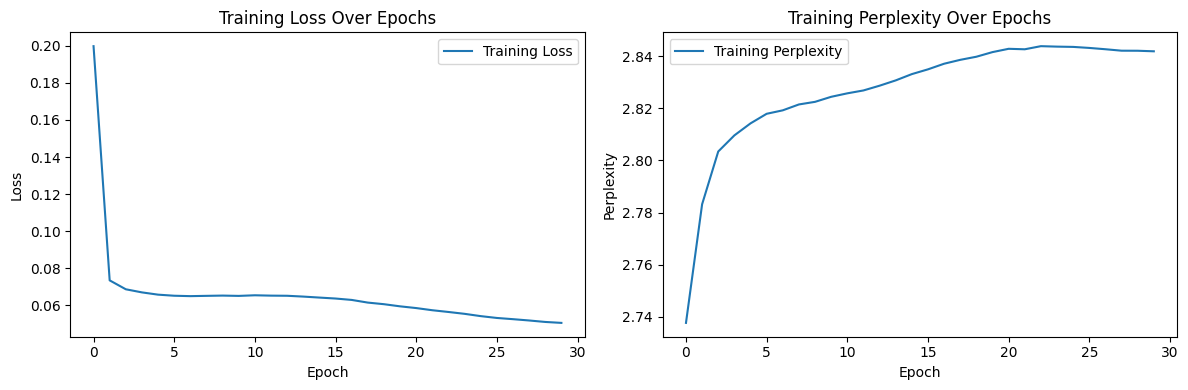

In [8]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_perplexities, label='Training Perplexity')
plt.title('Training Perplexity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.tight_layout()
plt.show()

we can see a steadily decreasing loss, which shows proper training.

## Evaluation

here to test the model and its reconstruction capabilities, we will plot the following:

- original input image
- reconstructed image
- codebook vectors

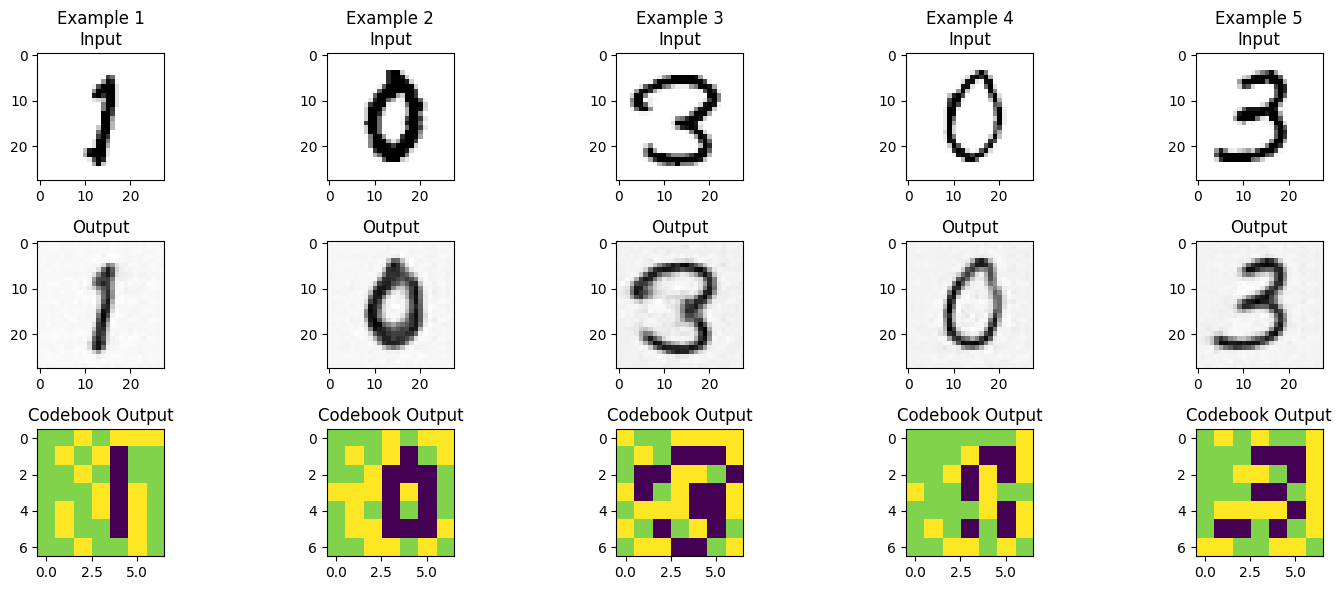

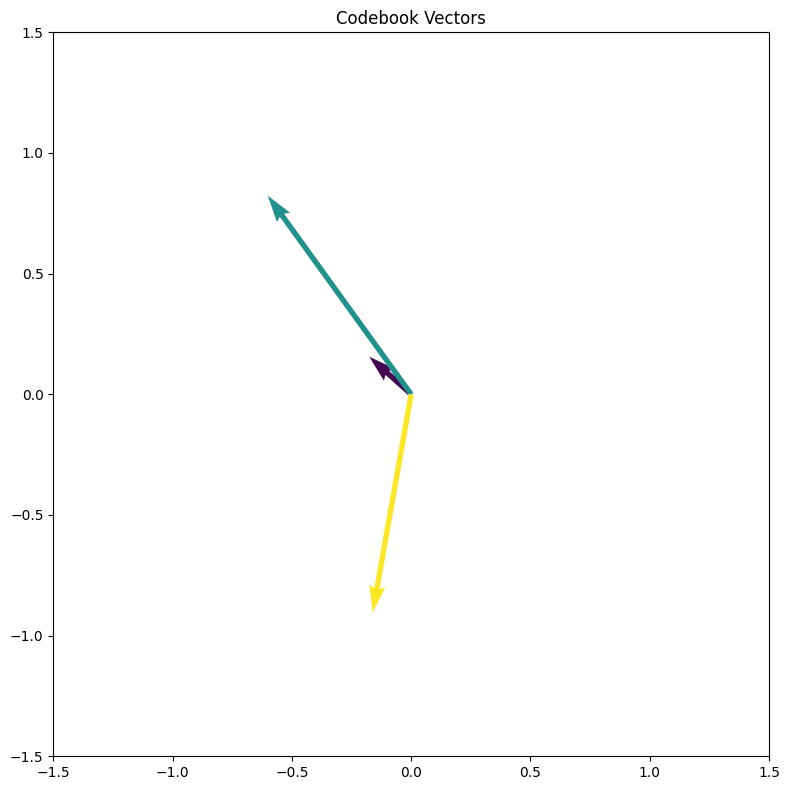

In [9]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

num_examples_to_plot = 5

test_examples = next(iter(train_loader))[:num_examples_to_plot]
inputs, _ = test_examples
inputs = inputs.to(device)

# Generate outputs
with torch.no_grad():
    encoded = encoder(inputs)
    codebook_output, _, _, _ = codebook(encoded) 
    outputs = decoder(codebook_output)

inputs = inputs.cpu().numpy()
outputs = outputs.cpu().numpy()
# codebook_output = codebook_output
pad = ((codebook_output[:, 0:1, :, :]) + (codebook_output[:, 1:2, :, :])) / 2
# codebook_output = torch.cat([pad, codebook_output], dim=1)
codebook_output = pad
codebook_output = codebook_output.cpu().numpy()
embedding_vectors = model.codebook.embedding.weight.data.cpu().numpy()

# Plot examples
plt.figure(figsize=(3 * num_examples_to_plot, 6))

for example_idx in range(num_examples_to_plot):
    plt.subplot(3, num_examples_to_plot, 1 + example_idx)
    plt.imshow(inputs[example_idx].transpose(1, 2, 0), cmap='Greys')
    plt.title(f'Example {example_idx + 1}\nInput')

    plt.subplot(3, num_examples_to_plot, 1 + example_idx + num_examples_to_plot)
    plt.imshow(outputs[example_idx].transpose(1, 2, 0), cmap='Greys')
    plt.title(f'Output')
    
    plt.subplot(3, num_examples_to_plot, 1 + example_idx + 2 * num_examples_to_plot)
    plt.imshow(codebook_output[example_idx].transpose(1, 2, 0),cmap='viridis')
    plt.title(f'Codebook Output')
# Plot codebook vectors separately
plt.tight_layout()
plt.show()

# Plot codebook vectors
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_vectors)))
plt.figure(figsize=(8, 8))

origin = np.array([np.zeros_like(embedding_vectors[:, 0]), np.zeros_like(embedding_vectors[:, 1])]) # origin point
plt.quiver(*origin, embedding_vectors[:, 0], embedding_vectors[:, 1], color=colors, scale_units='xy', angles='xy',
           scale=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title('Codebook Vectors')
plt.tight_layout()
plt.show()

as we can see from this result, we have a fairly good reconstruction, and a quantized representation on the codebook vector layers.

### Codebook vectors updates

here we will create an animation of how the codebook vectors are being updated in time.

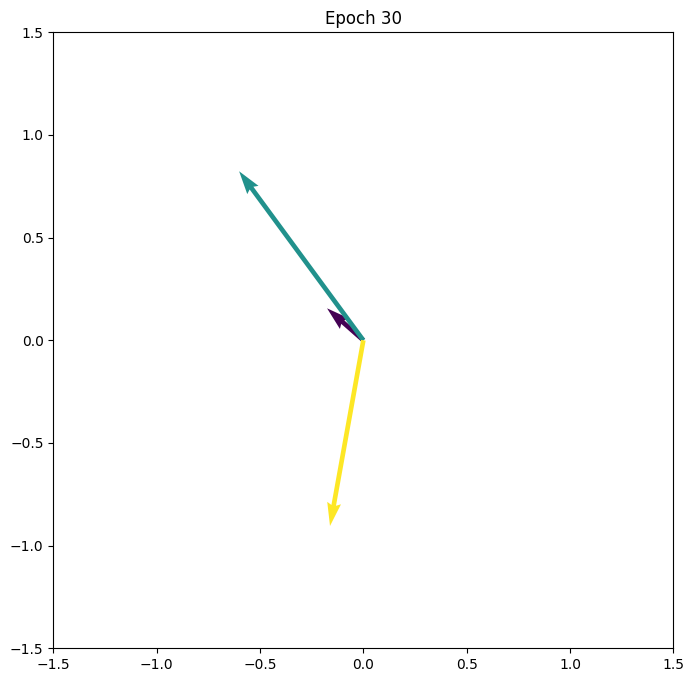

In [10]:
from matplotlib.animation import FuncAnimation

# Create a GIF
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Codebook Vectors Over Training')
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding_vectors)))

def update(frame):
    ax.clear()
    ax.quiver(np.zeros_like(codebook_vectors_list[frame][:, 0]),
              np.zeros_like(codebook_vectors_list[frame][:, 1]),
              codebook_vectors_list[frame][:, 0], codebook_vectors_list[frame][:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f'Epoch {frame + 1}')

ani = FuncAnimation(fig, update, frames=len(codebook_vectors_list), repeat=False)
ani.save('codebook_vectors_animation.gif', writer='imagemagick', fps=10)
plt.show()

# Testing different sizes

## Coloured dataset

here we create a coloured variant of the MNIST dataset by simply multiplying the mnist datamap by 3 random numbers, creating a 3 channel dataset.

Example Data Shape: torch.Size([3, 28, 28])


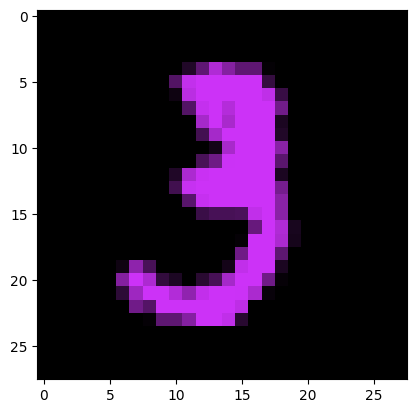

In [11]:
class ColouredMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=True, random_seed=42):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.random_seed = random_seed
        self.random_state = torch.manual_seed(self.random_seed)

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        # Set the random seed for reproducibility
        torch.manual_seed(self.random_seed * idx) # to make idx affect the colour
        original_data, target = self.mnist_dataset[idx]
        random_multipliers = torch.rand(3)
        three_channel_data = torch.cat([
            original_data * random_multipliers[0],
            original_data * random_multipliers[1],
            original_data * random_multipliers[2]],
            dim=0,
        )
        return three_channel_data, target

# Example
transform = transforms.ToTensor()
coloured_dataset = ColouredMNIST(root='./data', train=True, transform=transform, download=True)
batch_size = 256
coloured_loader = DataLoader(coloured_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False)

# Access an example from the custom dataset
example_data, _ = coloured_dataset[10]
print("Example Data Shape:", example_data.shape)
plt.imshow(example_data.cpu().numpy().transpose(1, 2, 0))

### Helper functions

here we define the functions `VQ_VAE_trained_model` and `sample_model_output` which will return a trained, VQ-VAE model on the provided dataset, and sample the generated outputs for a given model respectively.
these will help us in the next parts where we will train multiple models to test the effect of the codebook hyperparameters.

In [12]:
def VQ_VAE_trained_model(data_loader, input_dim, num_embeddings, embedding_dim,
                         device='cpu', num_epochs=30, print_idx=10, print_metric=False):
    encoder = Encoder(input_dim=input_dim, output_dim=embedding_dim)
    codebook = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    decoder = Decoder(input_dim=embedding_dim, output_dim=input_dim)

    model = VQ_VAE(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)
    recon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    beta = 0.25

    model.train()
    train_losses = []
    train_perplexities = []

    for epoch in tqdm(range(num_epochs), 
                      desc=f'Training model with {num_embeddings}, {embedding_dim} dimentional embeddings'):
        overall_loss = 0
        overall_perplexity = 0

        for (x, _) in (data_loader):
            x = x.to(device)
            optimizer.zero_grad()

            x_hat, commitment_loss, codebook_loss, perplexity = model(x)
            recon_loss = recon(x_hat, x)

            loss = recon_loss + codebook_loss + beta * commitment_loss

            overall_loss += loss.item()
            overall_perplexity += perplexity.item()

            loss.backward()
            optimizer.step()

        # Calculate mean loss and mean perplexity for the epoch
        mean_loss = overall_loss / len(train_loader)
        mean_perplexity = overall_perplexity / len(train_loader)

        # Print metrics once every two epochs
        if print_metric:
            if (epoch + 1) % print_idx == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Mean Loss: {mean_loss:.4f}, Mean Perplexity: {mean_perplexity:.4f}')

        # Save metrics for plotting
        train_losses.append(mean_loss)
        train_perplexities.append(mean_perplexity)
    
    metrics = {
        'loss': train_losses,
        'perplexity': train_perplexities,
    }
    
    return model, metrics

In [13]:
def sample_model_output(model, data_loader, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    model.eval()

    num_examples_to_plot = 5

    test_examples = next(iter(data_loader))[:num_examples_to_plot]
    inputs, _ = test_examples
    inputs = inputs.to(device)

    # Generate outputs
    with torch.no_grad():
        outputs, _, _, _ = model(inputs)

    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    embedding_vectors = model.codebook.embedding.weight.data.cpu().numpy()

    if ax is None:
        fig, ax = plt.subplots(2, num_examples_to_plot, figsize=(15, 6))

    for example_idx in range(num_examples_to_plot):
        ax[0, example_idx].imshow(inputs[example_idx].transpose(1, 2, 0))
        ax[0, example_idx].set_title(f'Example {example_idx + 1}\nInput')

        ax[1, example_idx].imshow(outputs[example_idx].transpose(1, 2, 0))
        ax[1, example_idx].set_title(f'Output')

    return ax


## Effect of number of embeddings

here we will create models with different number of embeddings to test its effect on the learnt model.

In [14]:
NumEmbeddings = [3, 5, 10, 20, 30, 40, 50]
modelsNum = [
    VQ_VAE_trained_model(coloured_loader, 3, num, 3, device) for num in NumEmbeddings
]

Training model with 50, 3 dimentional embeddings: 100%|██████████| 30/30 [03:14<00:00,  6.48s/it]


Model with 3 embedding vectors
final loss: 0.040864433268917366
final perplexity: 2.6014404509929903


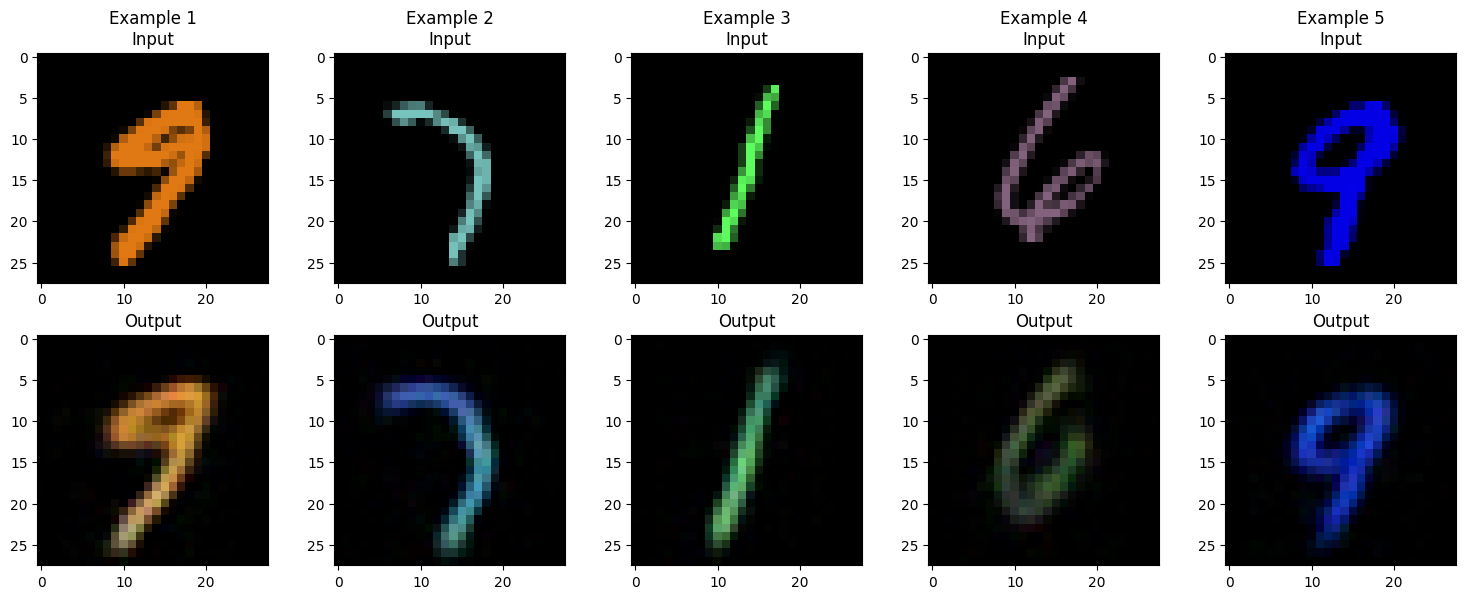

Model with 5 embedding vectors
final loss: 0.0309812854658416
final perplexity: 3.3151011284361496


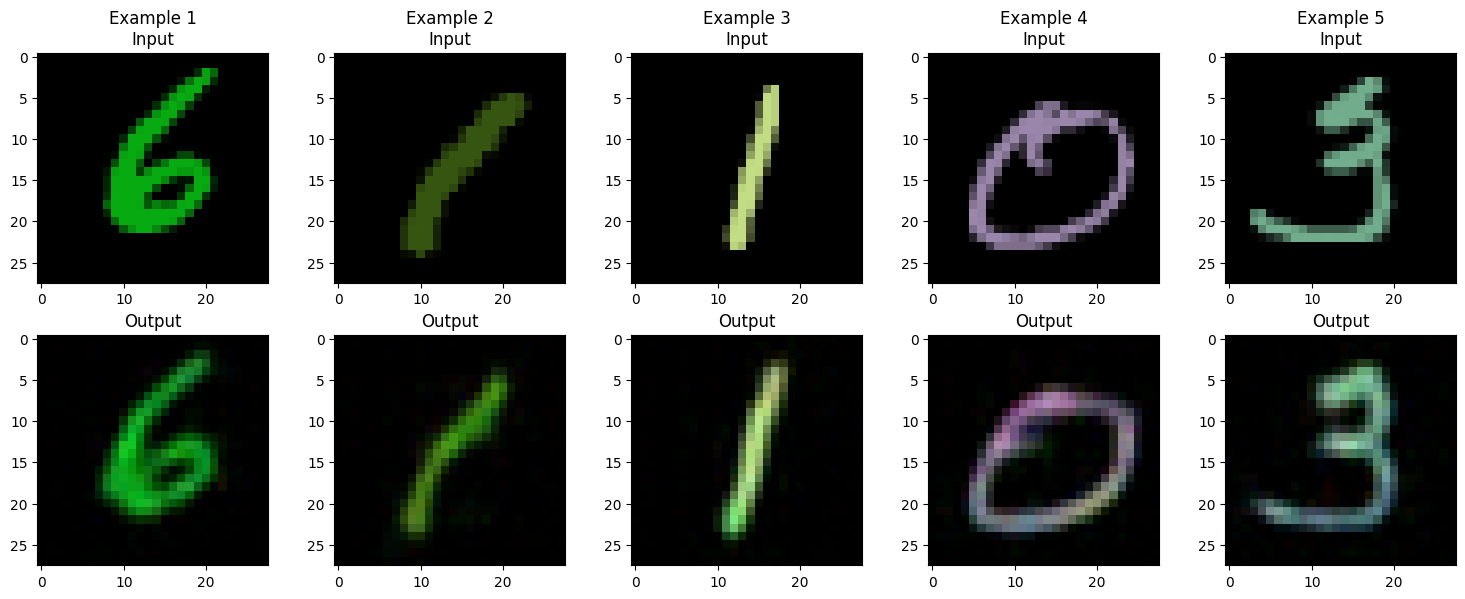

Model with 10 embedding vectors
final loss: 0.01282935297473314
final perplexity: 8.22248932452912


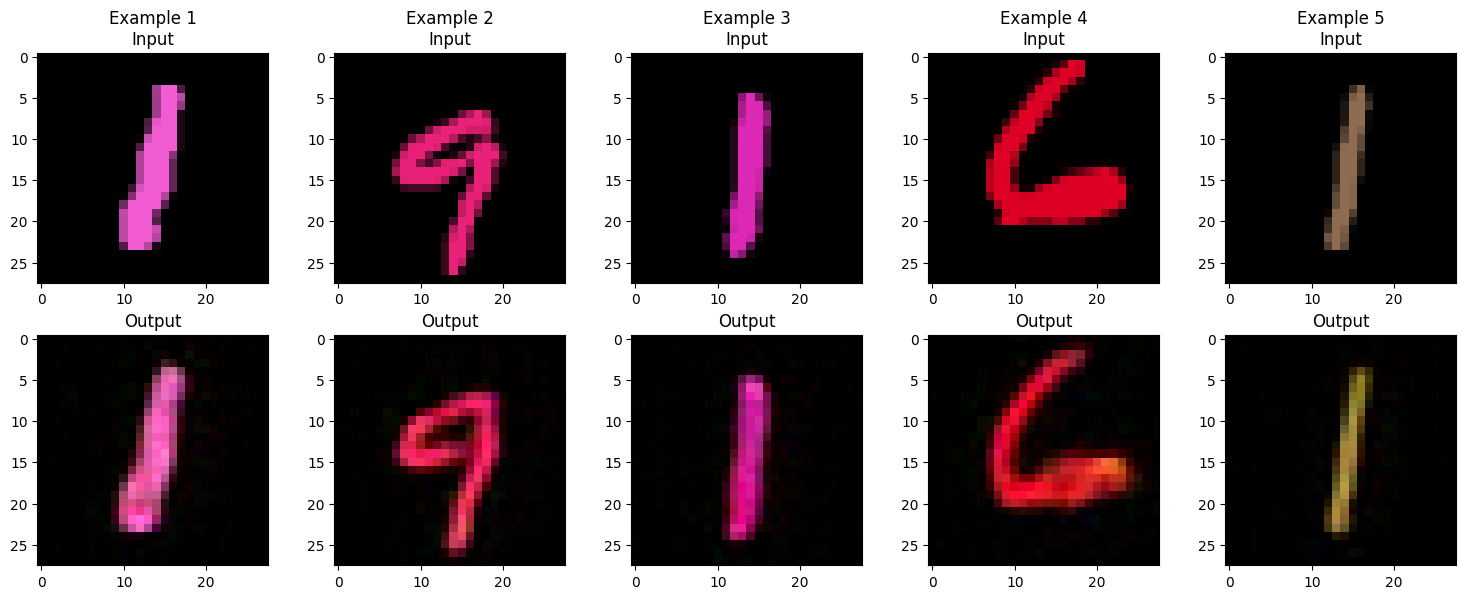

Model with 20 embedding vectors
final loss: 0.009085406521533397
final perplexity: 11.93055288436565


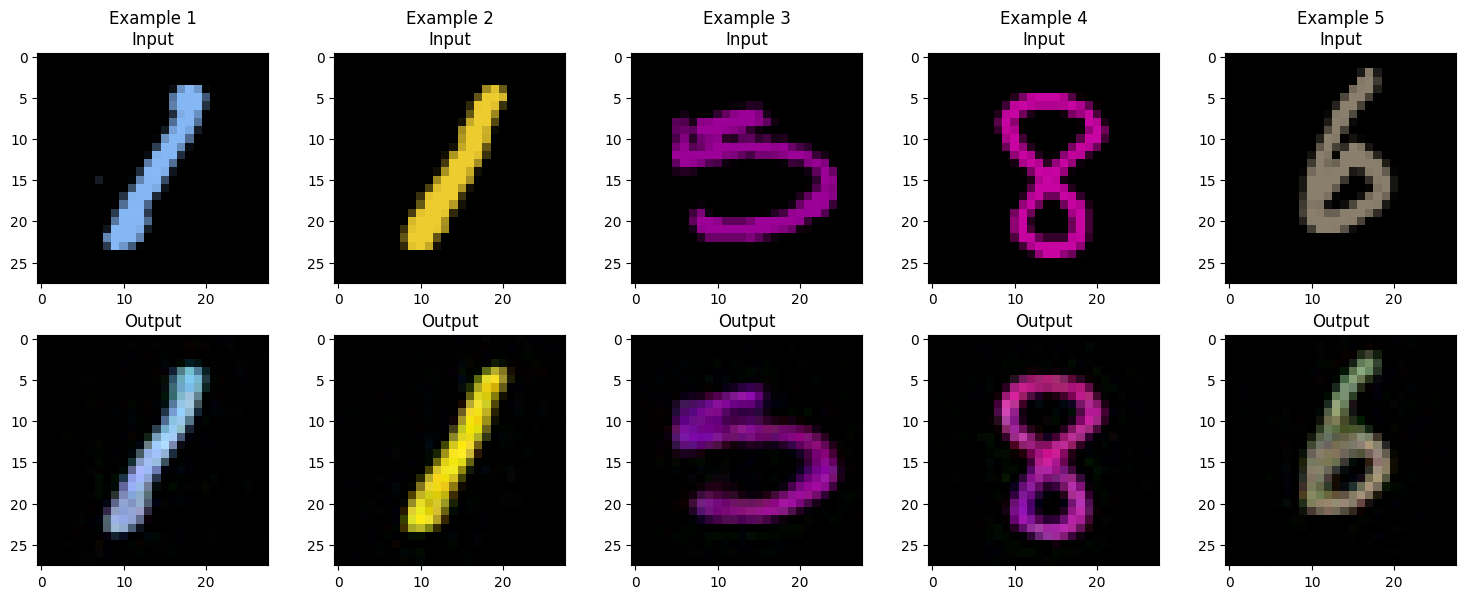

Model with 30 embedding vectors
final loss: 0.007090952292956571
final perplexity: 17.52971348052329


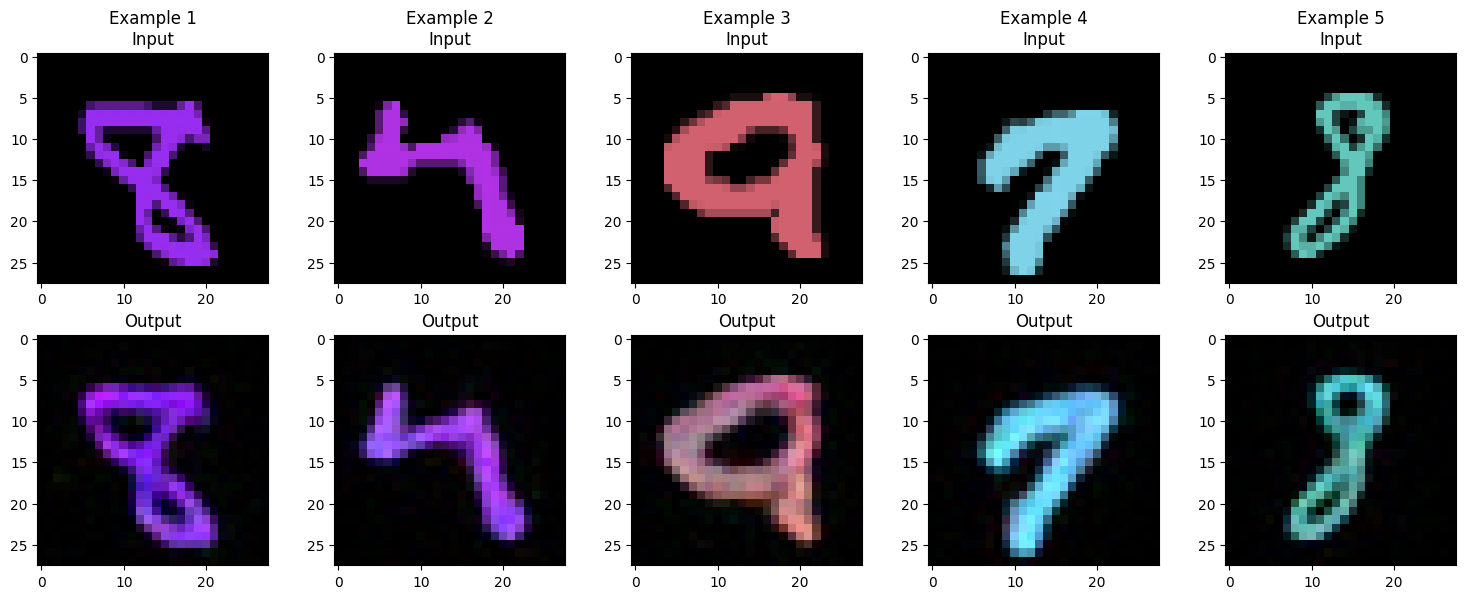

Model with 40 embedding vectors
final loss: 0.006668358228783658
final perplexity: 19.489138469290225


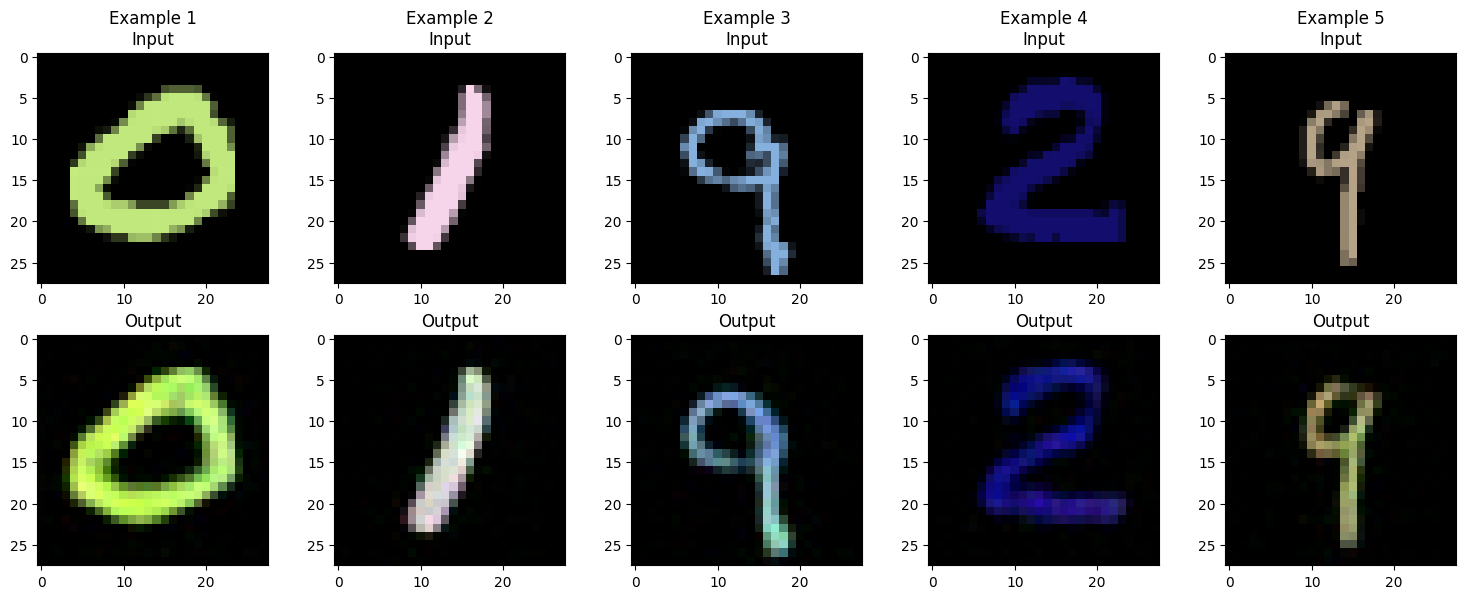

Model with 50 embedding vectors
final loss: 0.007022881743676485
final perplexity: 25.591864598051032


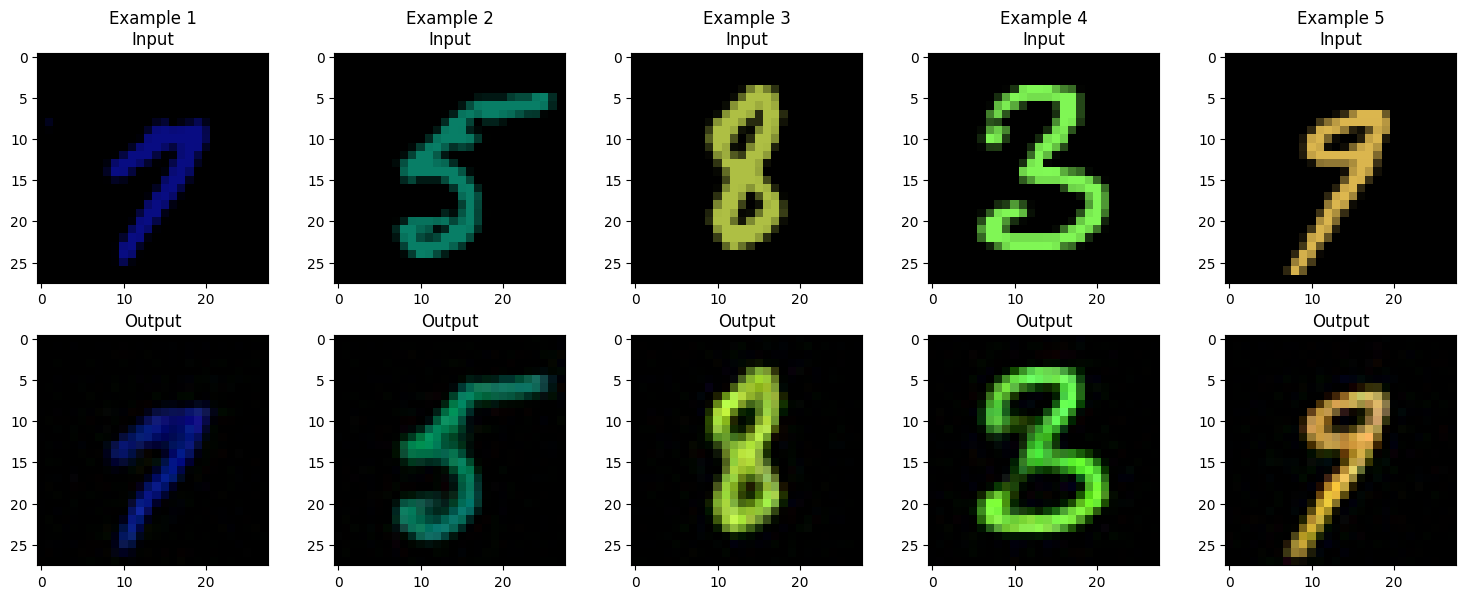

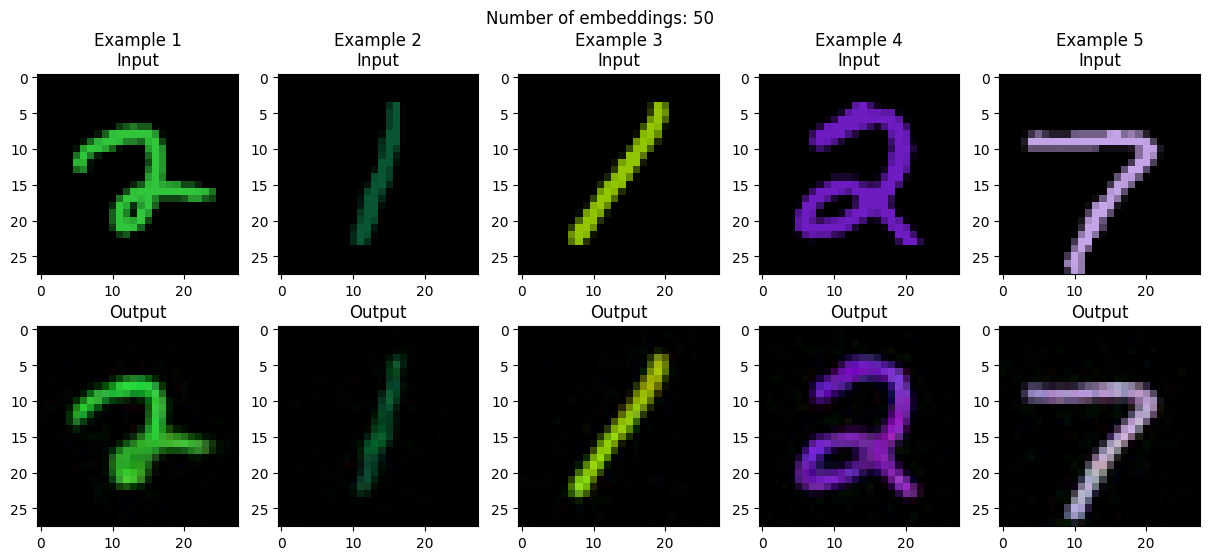

In [15]:
for idx, (model, metrics) in enumerate(modelsNum):
    print(f'Model with {NumEmbeddings[idx]} embedding vectors')
    final_loss = metrics['loss'][-1]
    final_perplexity = metrics['perplexity'][-1]
    print(f'final loss: {final_loss}')
    print(f'final perplexity: {final_perplexity}')
    sample_model_output(model, coloured_loader)
    plt.tight_layout()
    plt.show()
    
from matplotlib.animation import FuncAnimation

# Create a GIF
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
plt.title('Model Output Over Models')
colors = plt.cm.viridis(np.linspace(0, 1, len(modelsNum)))

def update(frame):
    model, metrics = modelsNum[frame]
    final_loss = metrics['loss'][-1]
    final_perplexity = metrics['perplexity'][-1]
    
    sample_model_output(model, coloured_loader, ax)
    fig.suptitle(f'Number of embeddings: {NumEmbeddings[frame]}')

ani = FuncAnimation(fig, update, frames=len(modelsNum), repeat=False)
ani.save('model_output_num_embedding_animation.gif', writer='imagemagick', fps=2)
plt.show()


as expected we observe better and better performance by increasing the number of vectors. reducing overall loss and increasing perplexity, while also creating better recreations.

## Effect of embedding dimension

here we will create models with different embedding dimensions to test its effect on the learnt model.

In [16]:
DimEmbeddings = [2, 5, 10, 20, 30, 40, 50]
modelsDim = [
    VQ_VAE_trained_model(coloured_loader, 3, 3, dim, device) for dim in DimEmbeddings
]

Training model with 3, 50 dimentional embeddings: 100%|██████████| 30/30 [03:18<00:00,  6.62s/it]


Model with 2 embedding dimension
final loss: 0.03678582976473139
final perplexity: 2.435600590198598


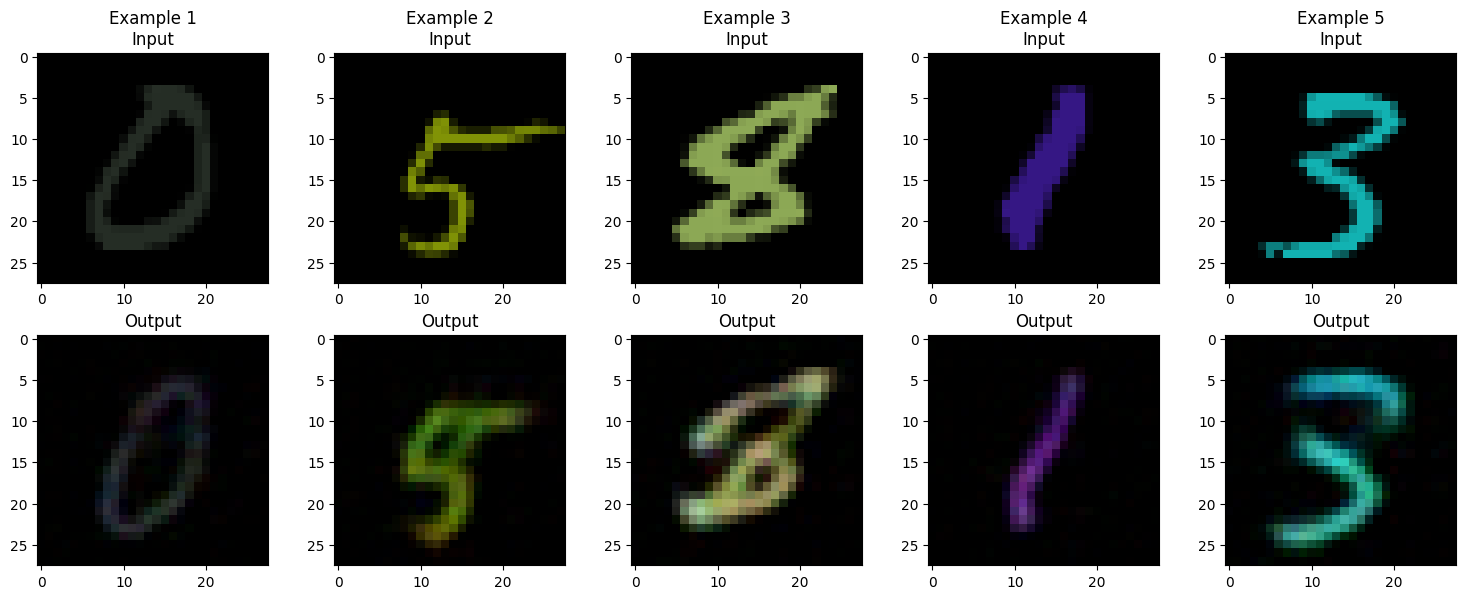

Model with 5 embedding dimension
final loss: 0.04028715989057054
final perplexity: 2.572482353575686


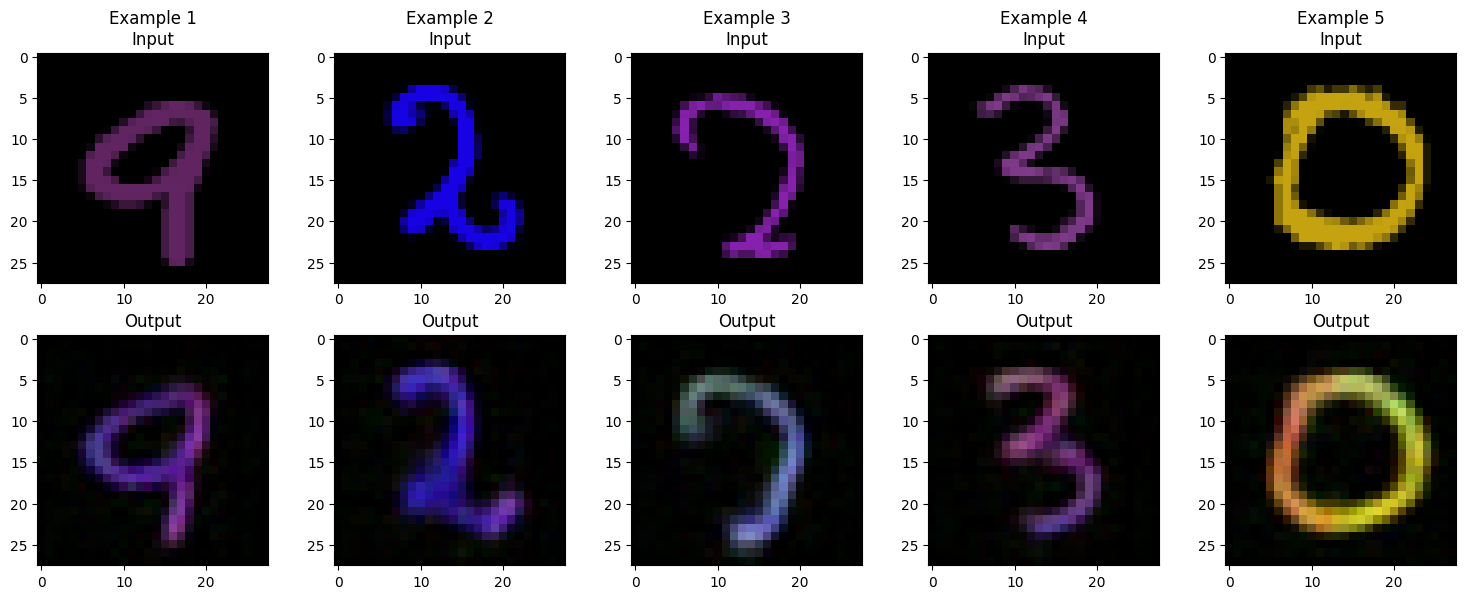

Model with 10 embedding dimension
final loss: 0.040255088802981884
final perplexity: 2.4814263424974805


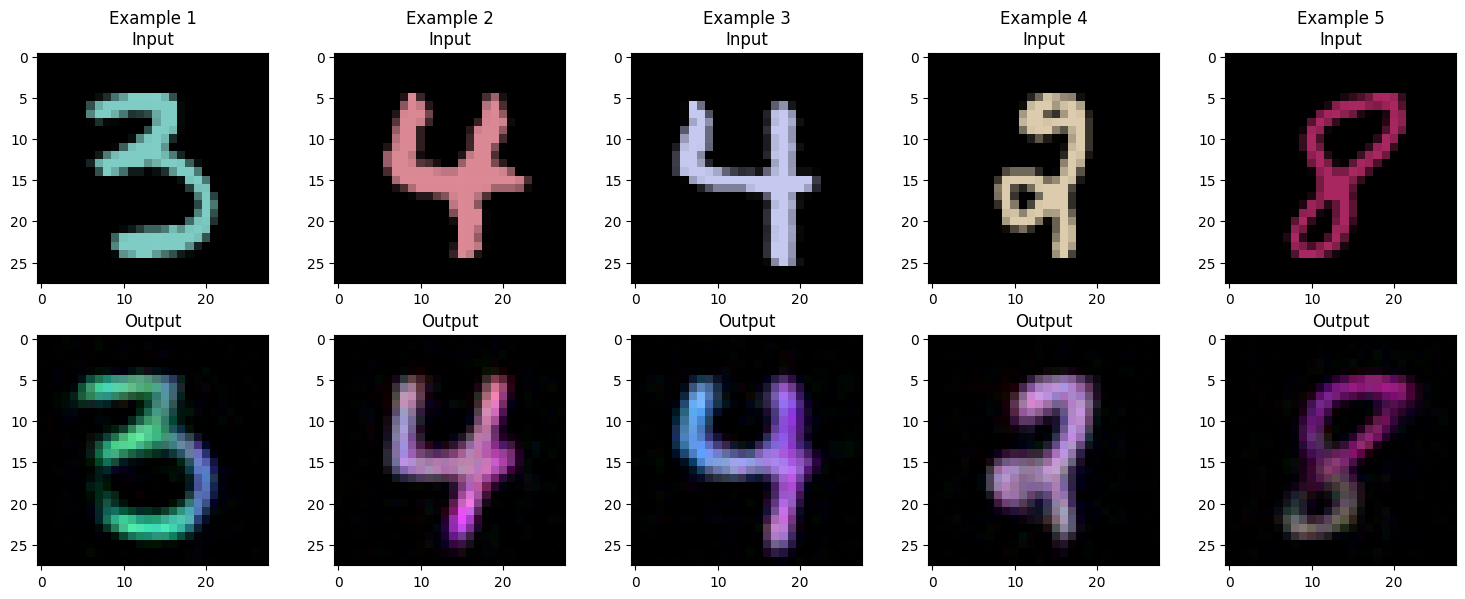

Model with 20 embedding dimension
final loss: 0.04184877079852084
final perplexity: 2.818124241524554


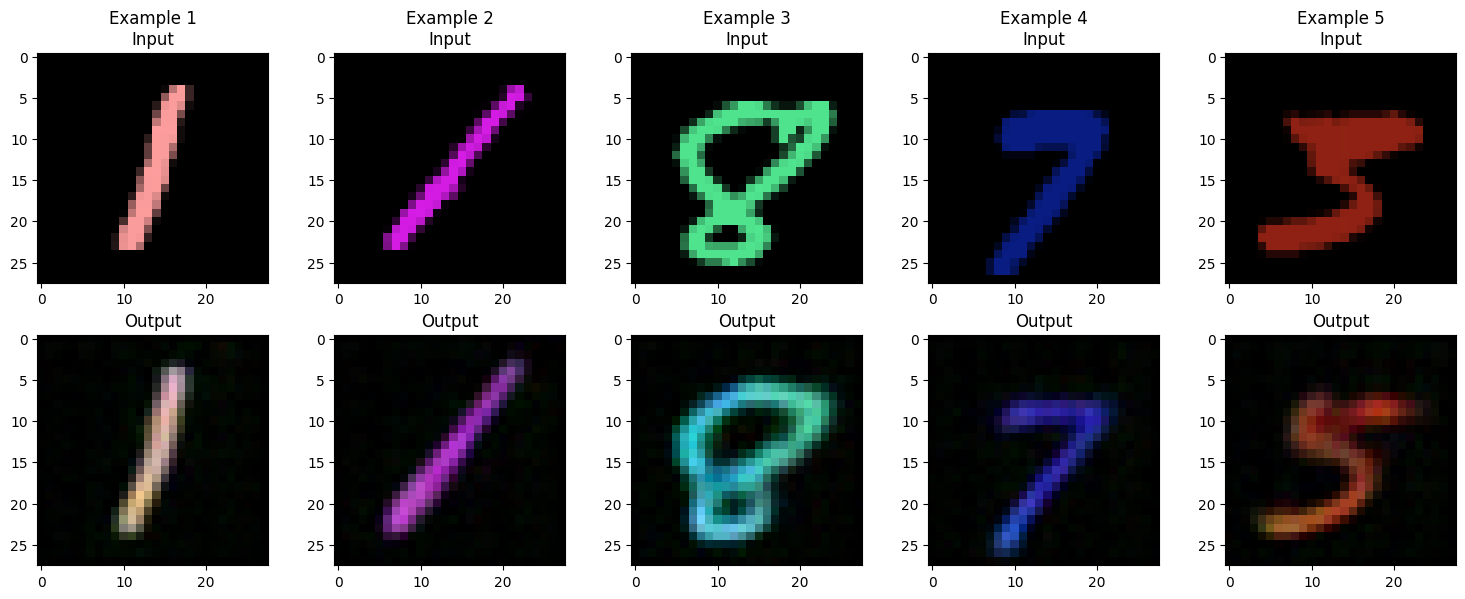

Model with 30 embedding dimension
final loss: 0.05075742955854599
final perplexity: 1.8657954576167655


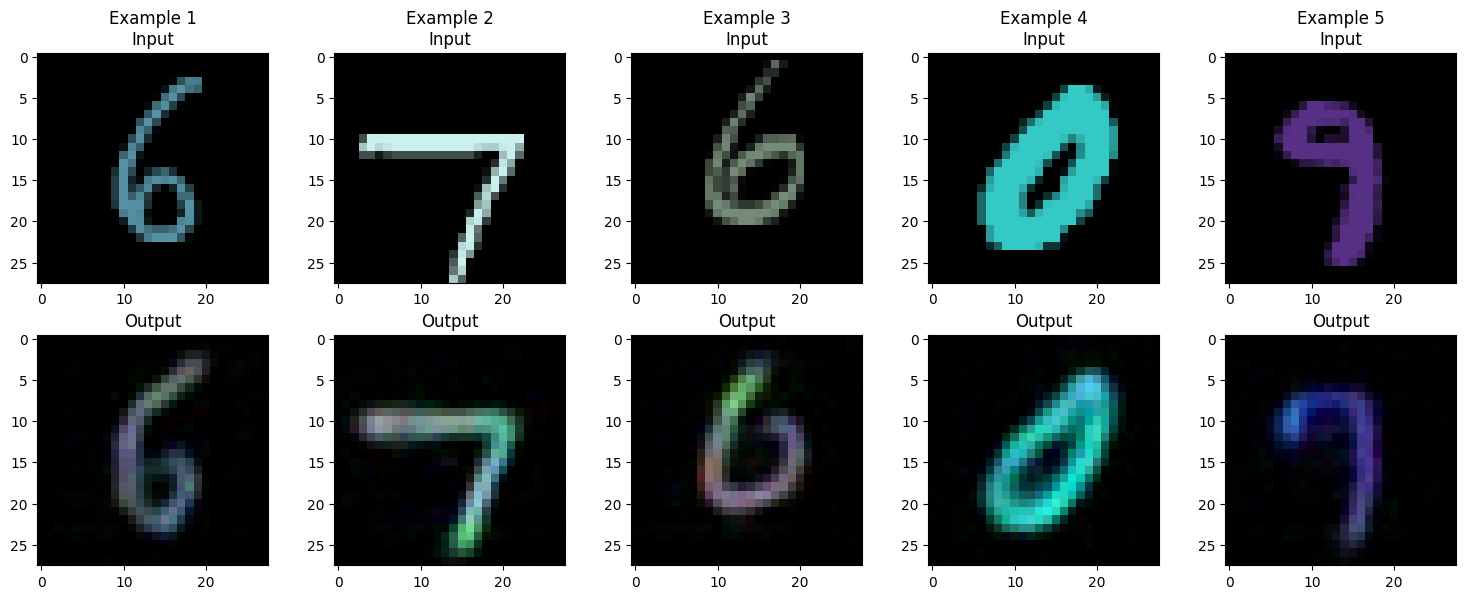

Model with 40 embedding dimension
final loss: 0.04142881387725789
final perplexity: 2.5669564906586992


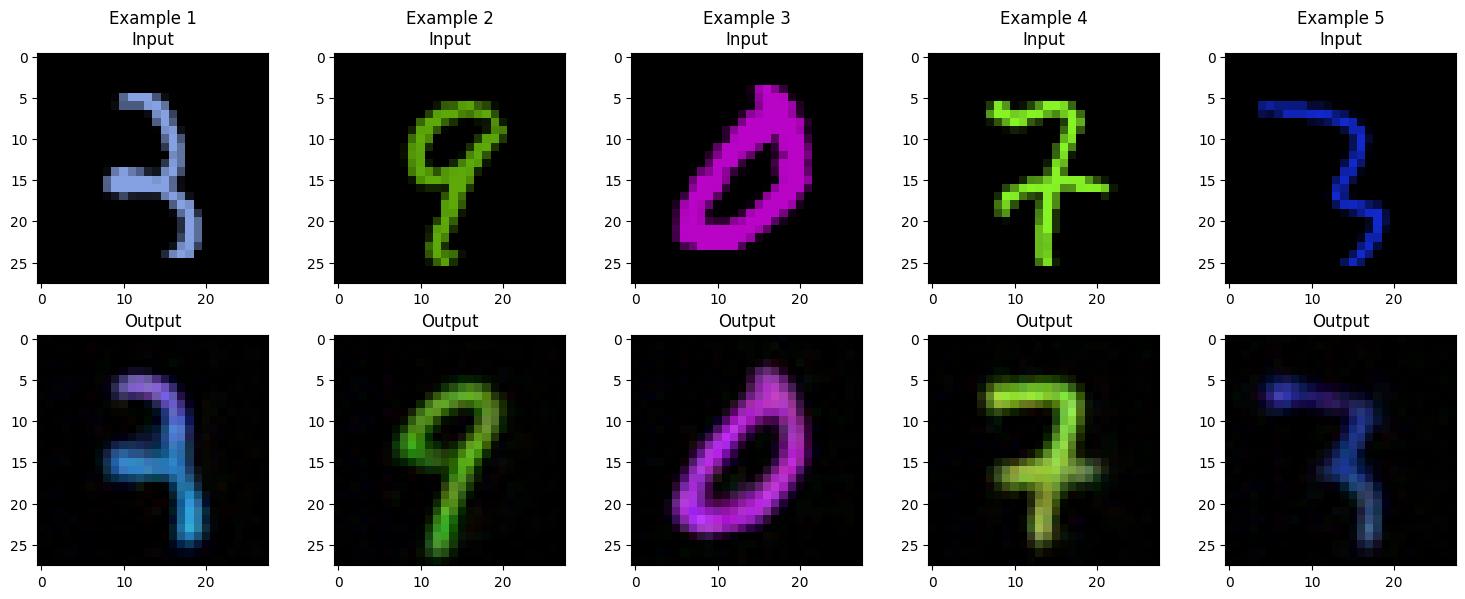

Model with 50 embedding dimension
final loss: 0.041793716413543576
final perplexity: 2.780257133727378


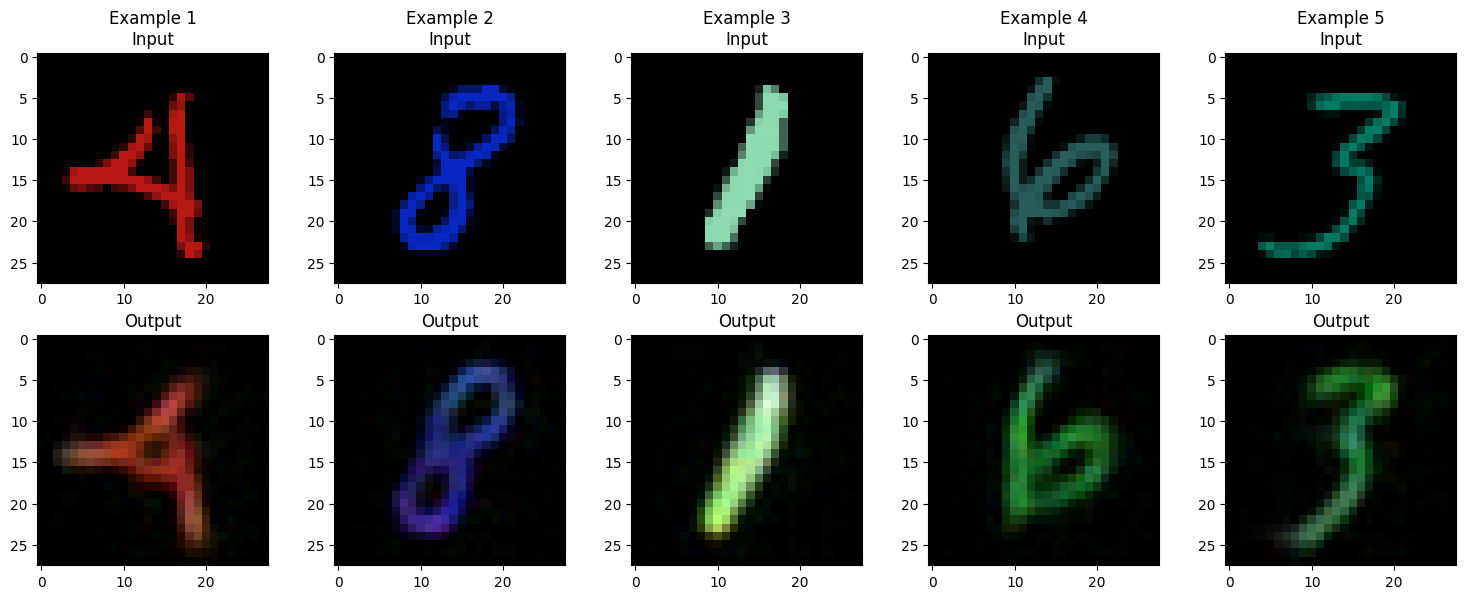

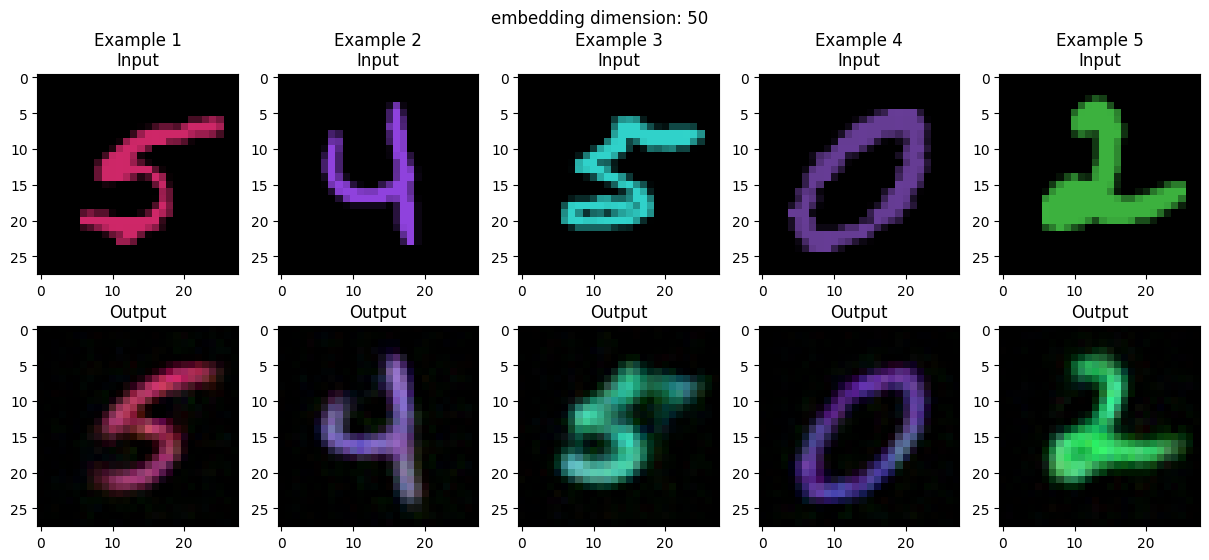

In [17]:
for idx, (model, metrics) in enumerate(modelsDim):
    print(f'Model with {DimEmbeddings[idx]} embedding dimension')
    final_loss = metrics['loss'][-1]
    final_perplexity = metrics['perplexity'][-1]
    print(f'final loss: {final_loss}')
    print(f'final perplexity: {final_perplexity}')
    sample_model_output(model, coloured_loader)
    plt.tight_layout()
    plt.show()
    
from matplotlib.animation import FuncAnimation

# Create a GIF
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
plt.title('Model Output Over Models')
colors = plt.cm.viridis(np.linspace(0, 1, len(modelsDim)))

def update(frame):
    model, metrics = modelsDim[frame]
    final_loss = metrics['loss'][-1]
    final_perplexity = metrics['perplexity'][-1]
    
    sample_model_output(model, coloured_loader, ax)
    fig.suptitle(f'embedding dimension: {DimEmbeddings[frame]}')

ani = FuncAnimation(fig, update, frames=len(modelsNum), repeat=False)
ani.save('model_output_dim_embedding_animation.gif', writer='imagemagick', fps=2)
plt.show()


as expected we observe better and better performance by increasing the vector dimensionality. reducing overall loss and increasing perplexity, while also creating better recreations.